Distributional Accuracy of Diffusion Graph Nets
-----------------------------------------------

The following notebook shows how to run and evaluate trained diffusion graph net models (DGNs). It also evaluates the accuracy of the inferred distributions in comparison to popular baselines. In the experiments here, the training trajectories are intentionally short. Specifically, the trajectories are too short to cover one full oscillation period, meaning they do not explicitly provide full statistical information about the systems. 

```{admonition} Learning with Partial Statistics
:class: tip
The key point to demonstrate below is the following: the diffusion training manages to learn complete statistics by combining the information _across multiple_ initial conditions and geometries. This is a very powerful capability that sets it apart from other Bayesian learning methods.
```

The `Ellipse` task used below involves a canonical fluid dynamics problem of predicting pressure $p$ field around an elliptical cylinder. It makes use of the graph-based representation by focusing solely on the surface of the immersed object, as shown below. This helps to reduce dimensionality, and as we'll focus on using pretrained models, it makes this notebook easy to run.

```{figure} resources/probmodels-graph-ellipse.jpg
---
height: 200px
name: probmodels-graph-ellipse
---
The `Ellipse` tasks focuses on predicting samples from the pressure distribution on the surface of a elliptical obstacle immersed in a fluid. The trained models should directly predict samples on the surface, without resolving the far field or the initial transient phase of the flow.
```
It's important to keep in mind that we don't resolve the full flow of time with this method (this was the task in {doc}`probmodels-time`). Rather, the goal is to very efficiently obtain samples from the equilibrium state of the simulation, as prescribed by the trianing data, not to resolve the evolution of an initial condition over time. A consequence is that trained models work on a graph that describes the geometry of the ellipse, but they are agnostic to time. They simply produce _one_ sample of the distribution of states of time. 

This in turn makes it more difficult to evaluate how closely a computed sample aligns with the ground truth: we don't know which sample out of the full distribution was generated! Thus, for a good test evaluation, it's important to have a densely sampled ground truth distribution, and for each sample inferred by a trained network, we'll search for the closest one in the test data set for the chosen input geometry. This can leave a small "discretization error" due to the discrete samples in the test set. It will nonetheless provide a good estimate of the distributional accuracy when enough samples are used on both sides, in terms of the test set itself, and the model outputs.



## Implementation

The following notebook uses the `dgn4cfd` [code](https://github.com/tum-pbs/dgn4cfd/), and hence we'll import some basic libraries and clone the `dgn4cfd` repo below. 


In [1]:
import numpy as np
import torch, tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
device = torch.device('cuda:0')

In [2]:
# NT_DEBUG, todo, install
# ! git clone https://github.com/tum-pbs/dgn4cfd
# % cd dgn4cfd/
import dgn4cfd as dgn 

To keep runtimes of this notebook low, we'll simply load pre-trained models from the repository. We'll compare the following variants:
- Diffusion Graph Net (DGN)
- Latent Diffusion Graph Net (LDGN)
- DGN (same as above) trained with Flow-Matching (FM-DGN)
- LDGN with Flow-Matching (FM-LDGN)
The last two show the advantages of the faster flow matching-based inference for the DGNs. Otherwise they're identical to the regular DGN/LDGN versions which use DDPM as underlying diffusion model.

We'll also load and evaluate a few baseline models, first of all a regular graph net with the same architecture as the DGN versions above. It already contains all the architectural tweaks, such as a hierarchy, but can show how much we gain (or loose) just by switching the regular, supervised training with a diffusion modeling process. Naturally, the vanilla Grap Net is fully deterministic, and can't provide a full distribution.
- Vanilla Graph Net
- Bayesian Graph Net
- Gaussian Mixure Graph Net
- Variational Graph Autoencoder (VGAE)

The last three baselines are probabilistic models, and as such they compete more directly with DGN: one would hope that they can likewise learn the posterior from the training data. As we'll see, DGN outperforms these baselines quite clearly.


In [4]:
# Diffusion Graph Net
DGN = dgn.nn.DiffusionGraphNet(
    checkpoint = "./checkpoints/dgn-nt10.chk",
    device     = device,
)

# Latent Diffusion Graph Net
LDGN = dgn.nn.LatentDiffusionGraphNet(
    autoencoder_checkpoint = "./checkpoints/ae-nt10.chk",
    checkpoint             = "./checkpoints/ldgn-nt10.chk",
    device                 = device,
)

# Vanilla Graph Net
VanillaGN = dgn.nn.VanillaGnn(
    checkpoint = "./checkpoints/vanilla-nt10.chk",
    device     = device,
) 

# Bayesian Graph Net
BayesianGN = dgn.nn.BayesianGnn(
    checkpoint = "./checkpoints/bayesian-nt10.chk",
    device     = device,
)

# Gassian Mixure Graph Net
GaussianMixGN = dgn.nn.GaussianMixtureGnn(
    checkpoint = "./checkpoints/gaussian-nt10.chk",
    device     = device,
)

# Variational Graph Autoencoder
VGAE = dgn.nn.VGAE(
    checkpoint = "./checkpoints/vgae-nt10.chk",
    device     = device,
)

# Flow-Matching Graph Net
FMGN = dgn.nn.FlowMatchingGraphNet(
    checkpoint = "./checkpoints/fmgn-nt10.chk",
    device     = device,
)

# Latent Flow-Matching Graph Net
LFMGN = dgn.nn.LatentFlowMatchingGraphNet(
    autoencoder_checkpoint = "./checkpoints/ae-nt10.chk",
    checkpoint             = "./checkpoints/lfmgn-nt10.chk",
    device                 = device,
)

As a next step, we need a test dataset to evaluate our models with. The `dgn4cfd` codebase contains several test and training data sets, but we'll use the `pOnEllipseInDist` dataset which contains partial distributions (similar to the training data), but with unseen conditions. We'll also load the `TimeEllipseInDist` dataset, which contains more samples and will provide a ground truth distribution for the evaluation.

The `transform` object configures the input geometries and meshes. In this example we'll use a hierarchy with 3 coarsened graph levels.


In [5]:
DATASET = dgn.datasets.DatasetUrl.pOnEllipseInDist
TIME_DATASET = dgn.datasets.DatasetUrl.TimeEllipseInDist 

# Training dataset
transform = transforms.Compose([
    dgn.transforms.MeshEllipse(),                               # Create a mesh on the ellipse
    dgn.transforms.ScaleEdgeAttr(0.02),                         # Scale the relative position stored as `edge_attr`
    dgn.transforms.EdgeCondFreeStreamProjection(),              # Add the projection of the free stream velocity along the edges as `edge_cond`
    dgn.transforms.ScaleAttr('target', vmin=-1.05, vmax=0.84),  # Scale the target field (pressure)
    dgn.transforms.ScaleAttr('glob',   vmin=500,   vmax=1000),  # Scale the global feature (Re)
    dgn.transforms.ScaleAttr('loc',    vmin=2,     vmax=3.5),   # Scale the local feature (distances to the walls)
    dgn.transforms.MeshCoarsening(                              # Create 3 lower-resolution graphs and normalise the relative position betwen the inter-graph nodes.
        num_scales      =  4,
        rel_pos_scaling = [0.02, 0.06, 0.15, 0.3],
        scalar_rel_pos  = True, 
    ),
])
dataset = dgn.datasets.pOnEllipse(
    path          = dgn.datasets.DatasetDownloader(DATASET).file_path,
    T             = 101,                    transform     = transform,
)
print('Number of samples:', len(dataset))

# Load the length of each simulation to compute statistics
T = dgn.datasets.DatasetDownloader(TIME_DATASET).numpy()

Dataset already exists.
Number of samples: 50
Dataset already exists.


The next cell defines a plotting function that shows the closest ground truth pressure distribution that was found in the reference data set in black next to the neural network outputs, shown in light red.

The `SIM_IDX` variable chooses a specific flow condition from the test data set (feel free to try others).

In [ ]:
SIM_IDX = 25

def plot(ax, pos, target, pred, r2, title):
    pos = pos.cpu()
    target = target.cpu()
    pred = pred.cpu()
    # Plots
    top = pos[:, 1] >= 0.5
    bottom = torch.logical_not(top)
    ax.plot(pos[top   , 0].cpu(), target[top   ].cpu(), 'k^', label='g.t.  top')
    ax.plot(pos[bottom, 0].cpu(), target[bottom].cpu(), 'kv', label='g.t.  bottom')
    ax.plot(pos[top,    0].cpu(), pred  [top   ].cpu(), '^', color="red", label='pred. top', alpha=0.6)
    ax.plot(pos[bottom, 0].cpu(), pred  [bottom].cpu(), 'v', color="red", label='pred. bottom', alpha=0.6)
    ax.set_title(title+r' ($R^2$ = ' + f"{r2:.4f}" + r')', fontsize=16)
    ax.set_ylabel(r'$p$', fontsize=16)
    ax.set_xlabel(r'$x$', fontsize=16)
    ax.grid()
    ax.legend(fontsize=16)


The next cell creates a 3x3 grid of graphs with the `plot()` function. The first row will contain the DGN models, and the vanilla GN. The next row will show flow-matching in direct comparison to the DDPM versions in the first row, while the last one will contain the outputs of the remaining three baseline.

DGN R2 = 0.9871 at t=31
LDGN R2 = 0.9987 at t=42
Vanilla Graph Net R2 = 0.9912 at t=6
Flow-Matching Graph Net R2 = 0.9970 at t=27
Latent Flow-Matching Graph Net R2 = 0.9985 at t=19
Bayesian Graph Net R2 = 0.9830 at t=67
Gaussian Mixture Graph Net R2 = 0.9690 at t=29
VGAE R2 = 0.9914 at t=55


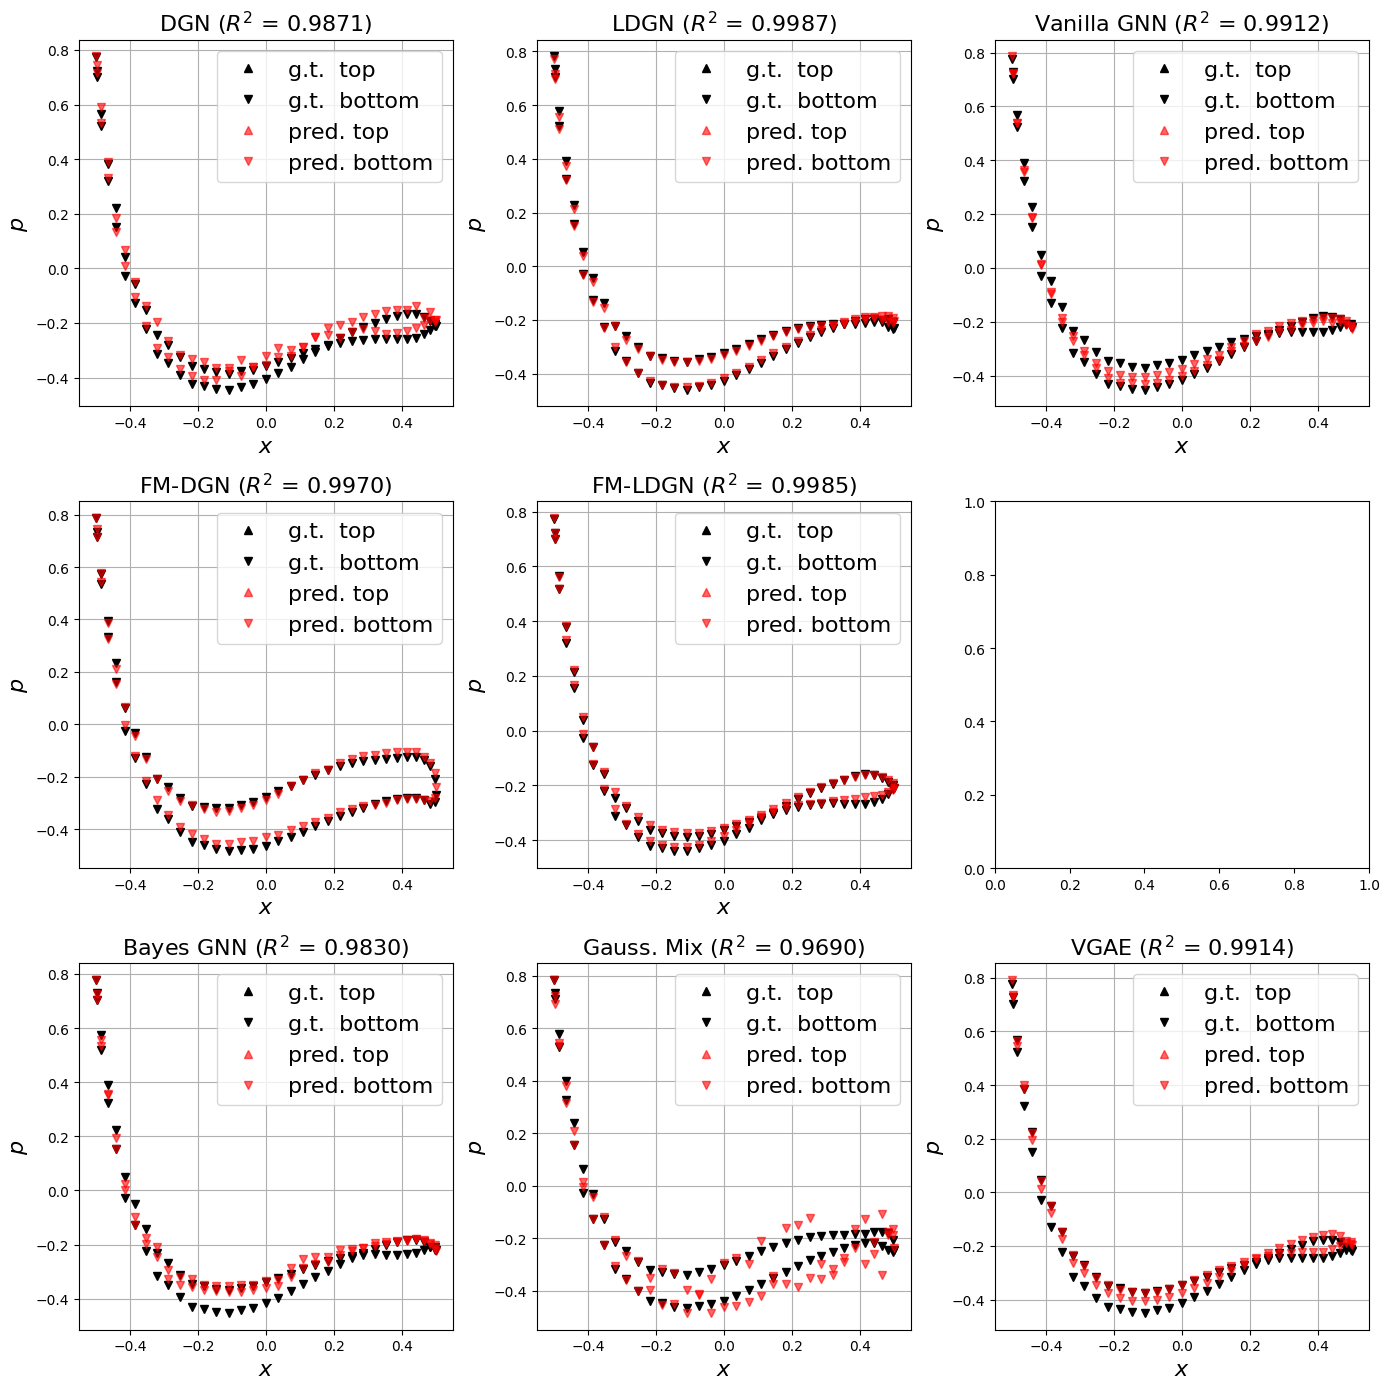

In [31]:
# denoising steps 
NUM_DENOISING_STEPS = 50
# flow matching steps
NUM_FM_STEPS = int(NUM_DENOISING_STEPS/10)+1

fig, ax = plt.subplots(3, 3, figsize=(14, 14))  
ax = ax.flatten()
curr_ax = 0

graph = dataset.get_sequence(SIM_IDX, n_in=T[SIM_IDX])

# DGN inference
steps = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS)
pred = DGN.sample(graph, steps=steps)
# Compute the accuracy
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)] 
r2, t = np.max(r2), np.argmax(r2)
print(f"DGN R2 = {r2:.4f} at t={t}")
# Plot the results
plot(ax[curr_ax],graph.pos, graph.target[:,t], pred, r2, "DGN")
curr_ax += 1

# LDGN inference
steps = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS)
pred = LDGN.sample(graph, steps=steps)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)] 
r2, t = np.max(r2), np.argmax(r2)
print(f"LDGN R2 = {r2:.4f} at t={t}")
plot(ax[curr_ax],graph.pos, graph.target[:,t], pred, r2, "LDGN")
curr_ax += 1

# Vanilla Graph Net inference
with torch.no_grad():
    VanillaGN.eval()
    pred = VanillaGN(graph)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)] 
r2, t = np.max(r2), np.argmax(r2)
print(f"Vanilla Graph Net R2 = {r2:.4f} at t={t}")
plot(ax[curr_ax], graph.pos, graph.target[:,t], pred, r2, "Vanilla GNN")
curr_ax += 1

# Flow matching versions

# Flow-Matching Graph Net inference
steps = np.linspace(0, 1, NUM_FM_STEPS)
pred = FMGN.sample(graph, steps=steps)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)]
r2, t = np.max(r2), np.argmax(r2)
print(f"Flow-Matching Graph Net R2 = {r2:.4f} at t={t}")
plot(ax[curr_ax],graph.pos, graph.target[:,t], pred, r2, "FM-DGN")
curr_ax += 1

# Latent Flow-Matching Graph Net inference
steps = np.linspace(0, 1, NUM_FM_STEPS)
pred = LFMGN.sample(graph, steps=steps) 
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)]
r2, t = np.max(r2), np.argmax(r2)
print(f"Latent Flow-Matching Graph Net R2 = {r2:.4f} at t={t}")
plot(ax[curr_ax],graph.pos, graph.target[:,t], pred, r2, "FM-LDGN")
curr_ax += 1

# skip one cell
curr_ax += 1 

# Other baselines following

# Bayesian Graph Net inference
pred = BayesianGN.sample(graph)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)]
r2, t = np.max(r2), np.argmax(r2)
print(f"Bayesian Graph Net R2 = {r2:.4f} at t={t}")
plot(ax[curr_ax],graph.pos, graph.target[:,t], pred, r2, "Bayes GNN")
curr_ax += 1

# Gaussian Mixture Graph Net inference
pred = GaussianMixGN.sample(graph)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)]
r2, t = np.max(r2), np.argmax(r2)
print(f"Gaussian Mixture Graph Net R2 = {r2:.4f} at t={t}")
# Plot the results
plot(ax[curr_ax],graph.pos, graph.target[:,t], pred, r2, "Gauss. Mix")
curr_ax += 1

# VGAE inference
pred = VGAE.sample(graph)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)]
r2, t = np.max(r2), np.argmax(r2)
print(f"VGAE R2 = {r2:.4f} at t={t}")
# Plot the results
plot(ax[curr_ax],graph.pos, graph.target[:,t], pred, r2, "VGAE")
curr_ax += 1


# Show the combined figure
plt.tight_layout()
plt.show()



There are a lot of graphs here, but they show several interesting aspects:
* First of all, the DGN and its FM variants produce very accurate pressure distributions; typically only the DGN version is slightly noise with the default settings (the latent space model LDGN already performs better).
* Flow matching uses one tenths of the steps (i.e. is 5x faster), but gives the same quality as denoising.
* The Bayes GNN has problems, and the Gaussian Mixture model produces clearly suboptimal outputs. We actually tuned this GM model quite a bit, but to no avail.
* The VGAE outputs often look surprisingly good here, but this holds only for a single sample. As we'll see, this model has trouble learning the proper distribution across many samples.

One difficulty here is that we're only seeing a single output. You'll see that re-running the cell will produce variants, but naturally, we'll need a thorough evaluation of the distributional accuracy of the models to properly draw conclusions about their performance.


## Evaluating Distributional Accuracy

To evaluate a large number of samples, and compute their node wise and graph-based Wasserstein distances. These quantified metrics are a good start, but it's still interesting to visualize the distributions to provide more intuition for how well or badly certain methods do. For this, we'll plot stacks of Gaussian kernel density estimates that show the distribution of pressure values along the length of the ellipses.

These plots can directly be compared in terms of how much density they contain in different regions of the plot. For reference, the distribution of the ground truth data is shown in the first cell below.



In [25]:
from scipy.stats import gaussian_kde

def pdf(ax, pos, pred, title, vmin=None, vmax=None, w2_distance_1d=None, w2_distance_nd=None):
    pos = pos.cpu()
    ang = torch.atan2(pos[:,1], pos[:,0])
    idx = torch.argsort(ang)
    idx = idx[ang[idx] > 0]
    y = pred[idx].cpu().numpy()
    if vmin is None:
        vmin = y.min() - 0.1
    if vmax is None:
        vmax = y.max() + 0.1
    x = np.linspace(vmin, vmax, 1000)
    f = np.stack([gaussian_kde(y[i])(x) for i in range(y.shape[0])])
    f = f / f.max(axis=1)[:,None]

    ax.imshow(np.flip(f.T), aspect='auto', cmap='binary')
    ax.set_yticks(np.linspace(100, 900, 5), np.flip(np.round(x[np.linspace(100, 900, 5).astype(int)], 2)), fontsize=16)
    ax.set_xticks([])
    #ax.set_yticks(fontsize=16)
    ax.set_title(title, fontsize=28)
    # Add a label with the Wasserstein-2 distance
    if w2_distance_1d is not None and w2_distance_nd is not None:
        ax.text(0.2, 0.76,  r'$W_2^\mathregular{node}$' + f'  = {w2_distance_1d:.4f} \n' + r'$W_2^\mathregular{graph}$' + f' = {w2_distance_nd:.4f}', fontsize=18, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'), transform=ax.transAxes)


We'll use `NUM_SAMPLES = 200` below, and plot the distributions for ground truth and the 8 models below.

DGN
R2 of mean: 0.9979 R2 of std: 0.9795
Wasserstein-2 distance 1d: 0.0143
Wasserstein-2 distance nd: 0.1854


LDGN
R2 of mean: 0.9987 R2 of std: 0.9650
Wasserstein-2 distance 1d: 0.0126
Wasserstein-2 distance nd: 0.1455


Flow-Matching DGN
R2 of mean: 0.9979 R2 of std: 0.4831
Wasserstein-2 distance 1d: 0.0221
Wasserstein-2 distance nd: 0.2149


Latent Flow-Matching DGN
R2 of mean: 0.9988 R2 of std: 0.8086
Wasserstein-2 distance 1d: 0.0150
Wasserstein-2 distance nd: 0.1568


100%|██████████| 200/200 [00:03<00:00, 54.93it/s]


Bayesian Graph Net
R2 of mean: 0.9983 R2 of std: -0.8248
Wasserstein-2 distance 1d: 0.0358
Wasserstein-2 distance nd: 0.5815


Gaussian Mixture Graph Net
R2 of mean: 0.9717 R2 of std: 0.1322
Wasserstein-2 distance 1d: 0.0528
Wasserstein-2 distance nd: 0.7149


VGAE
R2 of mean: 0.9986 R2 of std: 0.9365
Wasserstein-2 distance 1d: 0.0136
Wasserstein-2 distance nd: 0.2303


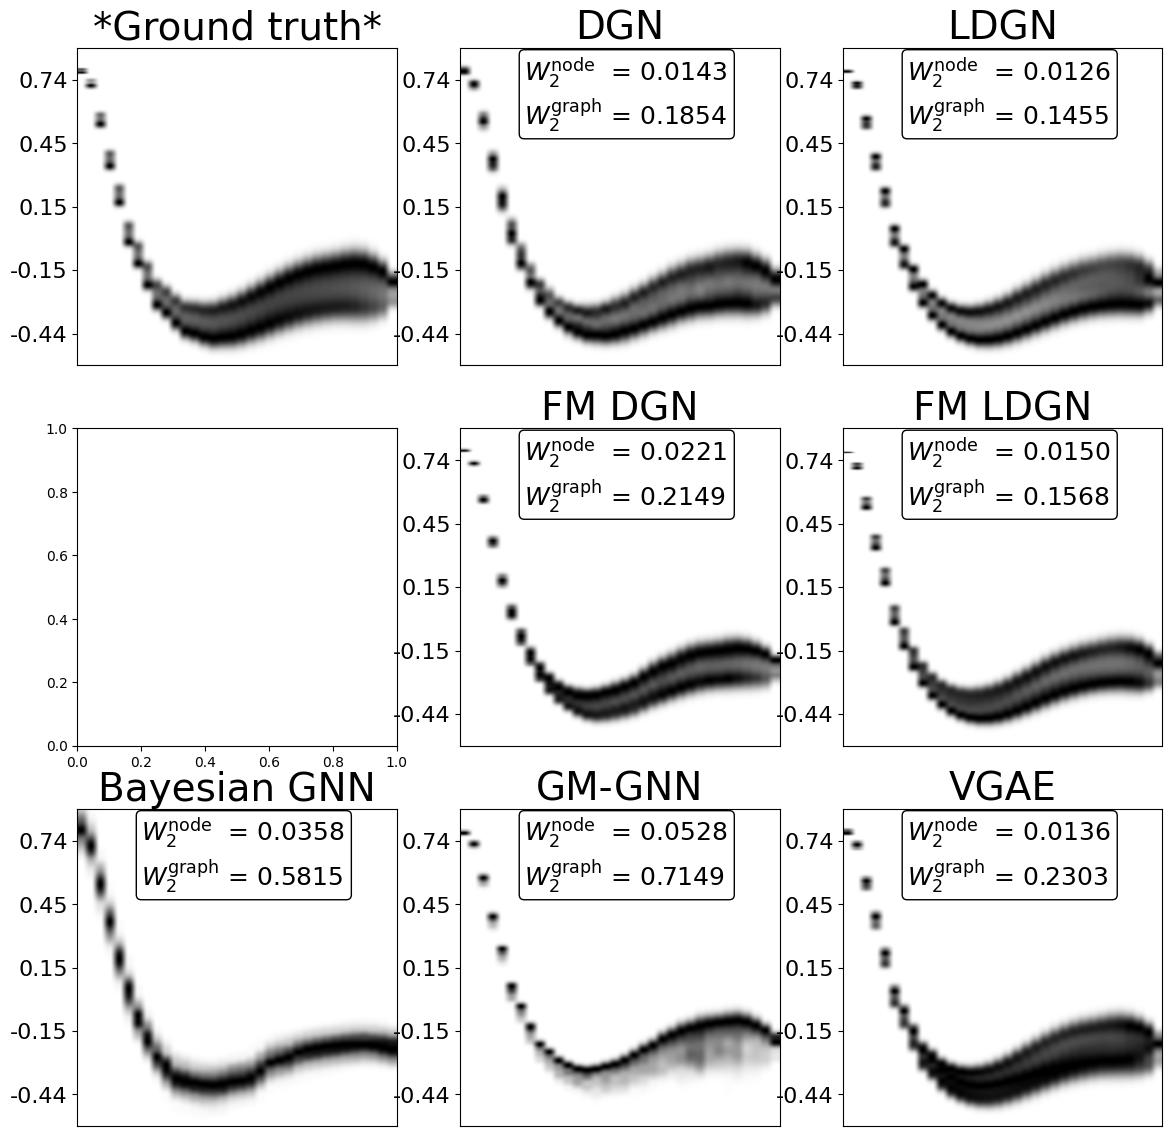

In [36]:
NUM_SAMPLES = 200
BATCH_SIZE  = 200 # Number of samples generated in parallel. Reduce this number if you run out of memory.

fig, ax = plt.subplots(3, 3, figsize=(14, 14))  
ax = ax.flatten()
curr_ax = 0

graph = dataset.get_sequence(SIM_IDX, n_in=T[SIM_IDX])
gt_mean = graph.target.mean(dim=1)
gt_std  = graph.target.std (dim=1)
# Plot the ground-truth PDF on the upper half of the ellipse
vmin, vmax = graph.target.min().item() - 0.1, graph.target.max().item() + 0.1
pdf(ax[curr_ax], graph.pos, graph.target, '*Ground truth*', vmin=vmin, vmax=vmax)
curr_ax += 1

# DGN inference
steps = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS)
pred = DGN.sample_n(NUM_SAMPLES, graph, steps=steps, batch_size=BATCH_SIZE).cpu().squeeze(-1)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('DGN')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the PDF on the upper half of the ellipse
pdf(ax[curr_ax], graph.pos, pred, 'DGN', w2_distance_1d=w2_distance_1d, w2_distance_nd=w2_distance_nd, vmin=vmin, vmax=vmax)
curr_ax += 1

# LDGN inference
steps = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS)
pred = LDGN.sample_n(NUM_SAMPLES, graph,  steps=steps, batch_size=BATCH_SIZE).cpu().squeeze(-1)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('LDGN')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
pdf(ax[curr_ax], graph.pos, pred, 'LDGN', w2_distance_1d=w2_distance_1d, w2_distance_nd=w2_distance_nd, vmin=vmin, vmax=vmax)
curr_ax += 1

# skip one
curr_ax += 1

# FMGN inference
steps = np.linspace(0, 1, NUM_FM_STEPS )
pred = FMGN.sample_n(NUM_SAMPLES, graph, steps=steps, batch_size=BATCH_SIZE).cpu().squeeze(-1)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('Flow-Matching DGN')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
pdf(ax[curr_ax], graph.pos, pred, 'FM DGN', w2_distance_1d=w2_distance_1d, w2_distance_nd=w2_distance_nd, vmin=vmin, vmax=vmax)
curr_ax += 1

# LFMGN inference
steps = np.linspace(0, 1, NUM_FM_STEPS )
pred = LFMGN.sample_n(NUM_SAMPLES, graph, steps=steps, batch_size=BATCH_SIZE).cpu().squeeze(-1)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('Latent Flow-Matching DGN')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
pdf(ax[curr_ax], graph.pos, pred, 'FM LDGN', w2_distance_1d=w2_distance_1d, w2_distance_nd=w2_distance_nd, vmin=vmin, vmax=vmax)
curr_ax += 1

# Bayesian Graph Net inference
pred_list = []
for _ in tqdm.tqdm(range(NUM_SAMPLES)):
    pred_list.append(
        BayesianGN.sample(graph).cpu()
    )
pred = torch.concatenate(pred_list, dim=1) 
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('Bayesian Graph Net')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
pdf(ax[curr_ax], graph.pos, pred, 'Bayesian GNN', w2_distance_1d=w2_distance_1d, w2_distance_nd=w2_distance_nd, vmin=vmin, vmax=vmax)
curr_ax += 1

# Gaussian Mixture Graph Net inference
pred = GaussianMixGN.sample_n(NUM_SAMPLES, graph, batch_size=BATCH_SIZE).cpu().squeeze(-1)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('Gaussian Mixture Graph Net')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
pdf(ax[curr_ax], graph.pos, pred, 'GM-GNN', w2_distance_1d=w2_distance_1d, w2_distance_nd=w2_distance_nd, vmin=vmin, vmax=vmax)
curr_ax += 1

# VGAE inference
pred = VGAE.sample_n(NUM_SAMPLES, graph, batch_size=BATCH_SIZE).cpu().squeeze(-1)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('VGAE')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
pdf(ax[curr_ax], graph.pos, pred, 'VGAE', w2_distance_1d=w2_distance_1d, w2_distance_nd=w2_distance_nd, vmin=vmin, vmax=vmax)
curr_ax += 1


First, the ground truth distribution is worth a closer look: it's a bi-modal distribution, caused by the recurring vortex shedding behind the ellipse. Hence, it's important for models to capture the two extremes (regions with higher density), as well as the less dense inner part. Comparing the GT version with the distributions of the different approaches shows that the DGN methods faithfully reproduce the distribution. The noise of the regular DGN averages out to some extent here, it can even exhibit a performance that surpasses the LDGN version. As before, flow matching can produce these distributions at a fraction of the cost, and hence is generally preferable.

The problems of the Baysian NN and the Gaussian mixture model very clearly show up in their distributions. The problems of the VGAE approach show up more clearly here: it has mode-collapse issues, which are even more severe in more complex scenarios.

The graph-based Wasserstein distance largely captures the intuition behind the observations above, but fails to illustrate how well outer (and inner) parts of the distribution are matched. Nonetheless, it's of course crucial as a tool for higher-dimensional distributions such as those of the 3D wing case from the previous page. 
